In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from ptlpinns.odes import numerical, equations
from ptlpinns.perturbation import LKV
from scipy.interpolate import CubicSpline
import torch

## Equation parameters

In [47]:
alpha = 0.2
x0, y0 = 1.59, 0.95
t_span = (0, 10)
N = 51200
t_eval = np.linspace(t_span[0], t_span[1], N)

## Lotka-Volterra RK45 solution

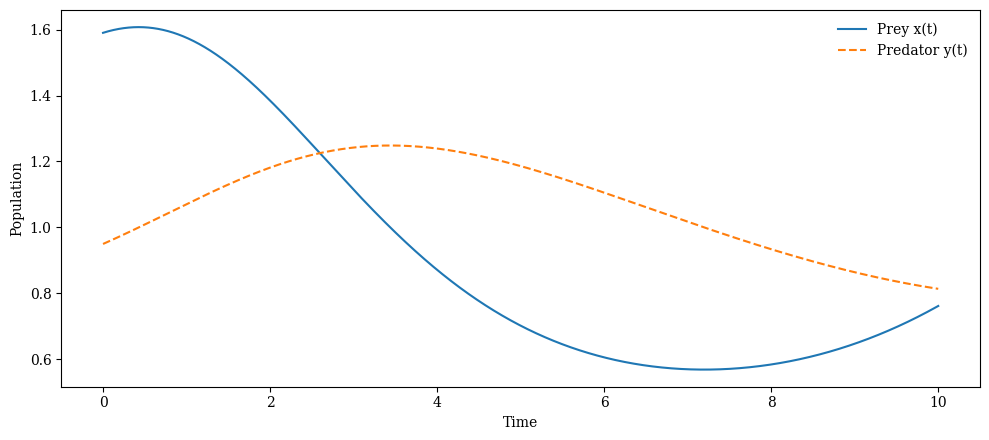

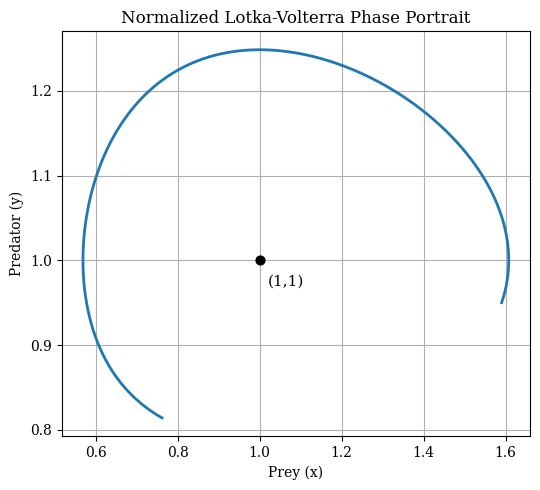

In [48]:
ode = equations.lv_normalized(alpha)

sol = numerical.solve_ode_equation(ode, t_span, t_eval, [x0, y0])
x, y = sol  # unpack solution components

LKV.plot_numerical_LKV(x, y, t_eval)

## Perturbation solution


In [49]:
epsilon = 0.5
xi0 = (x0 - 1) / epsilon
eta0 = (y0 - 1) / epsilon
w_0 = np.sqrt(alpha)

In [50]:
xi0, eta0

(1.1800000000000002, -0.10000000000000009)

### 0th-order solution

In [51]:
correction_0 = numerical.solve_ode_equation(equations.lv_0th_order(alpha), t_span, t_eval, [xi0, eta0])
xi_0, eta_0 = correction_0

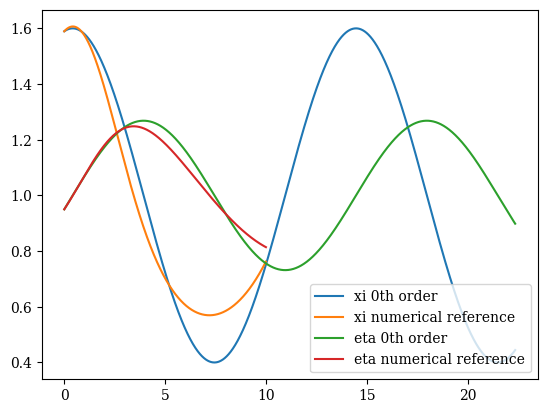

In [52]:
# don't forget xi_0 is defined in tau!
plt.plot(t_eval / np.sqrt(alpha), 1 + epsilon * xi_0, label="xi 0th order")
plt.plot(t_eval, x, label="xi numerical reference")

plt.plot(t_eval / np.sqrt(alpha), 1 + epsilon * eta_0, label="eta 0th order")
plt.plot(t_eval, y, label="eta numerical reference")
plt.legend()

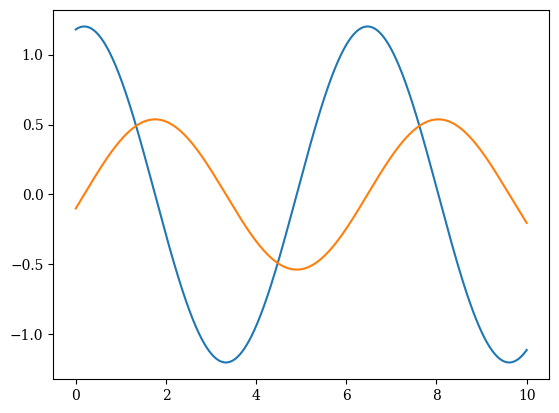

In [53]:
plt.plot(t_eval, xi_0)
plt.plot(t_eval, eta_0)

### Solving higher-orders

calculating term p: 1
omega 1: -3.190471535026614e-07


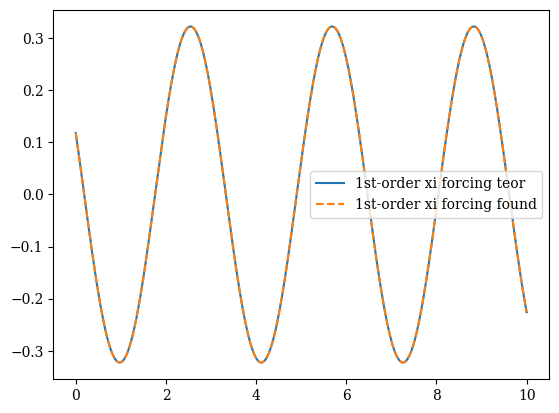

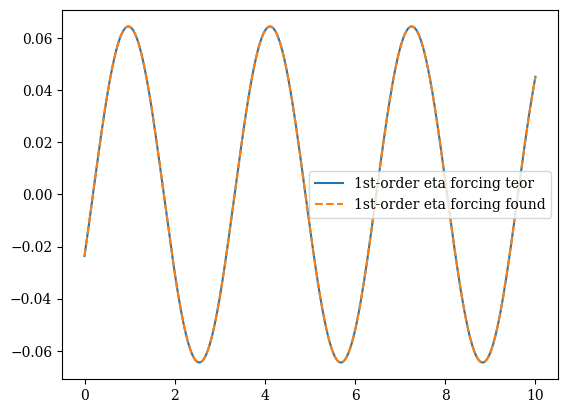

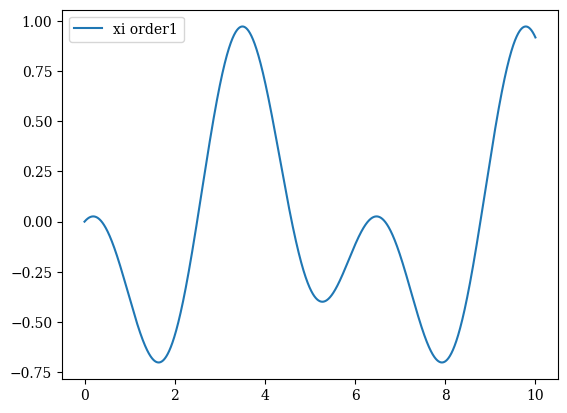

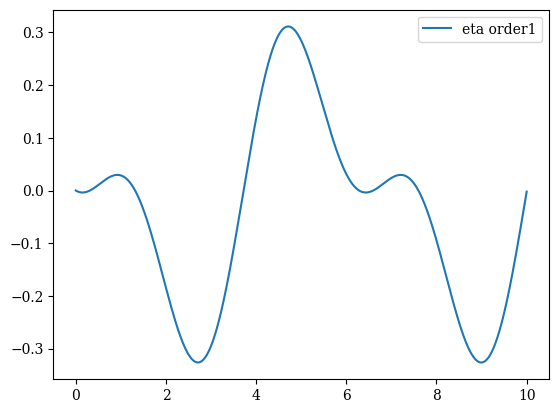

calculating term p: 2
omega 2: -0.05375495941304092


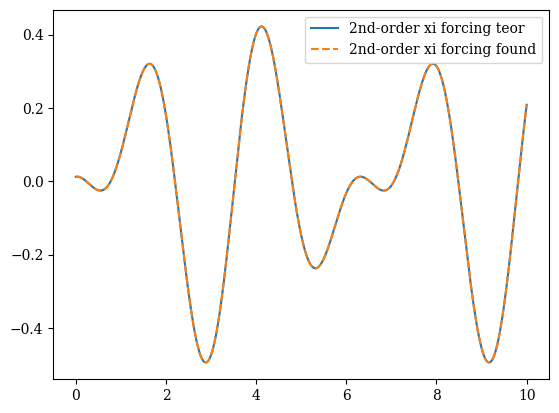

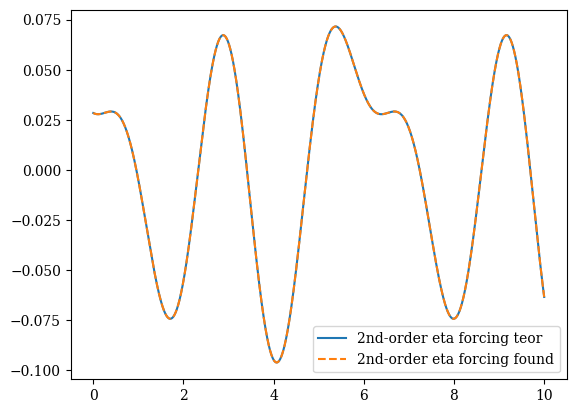

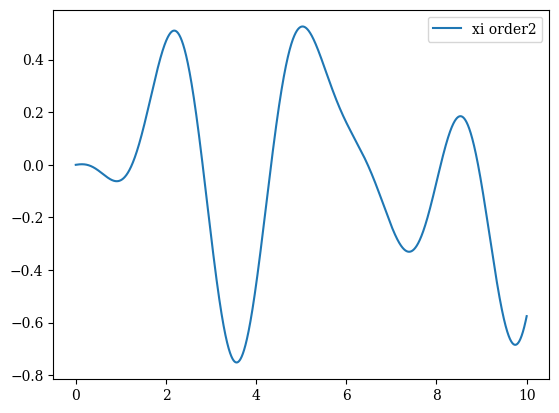

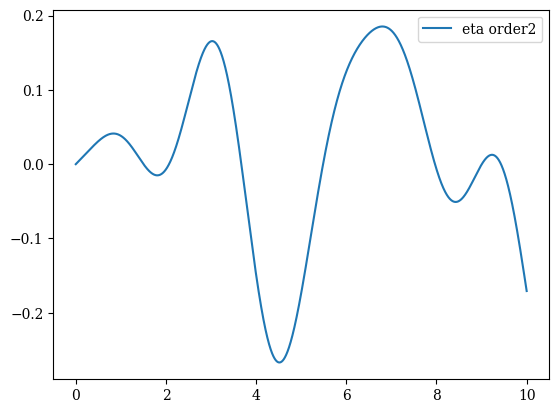

calculating term p: 3
omega 3: 0.06292964564752389


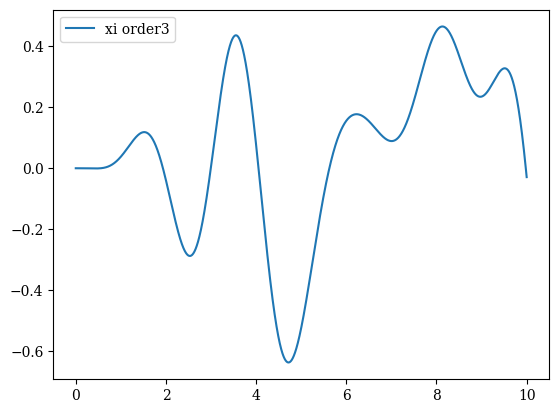

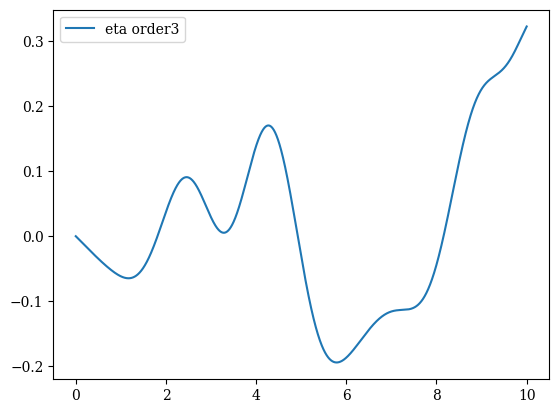

calculating term p: 4
omega 4: -0.057301925925424935


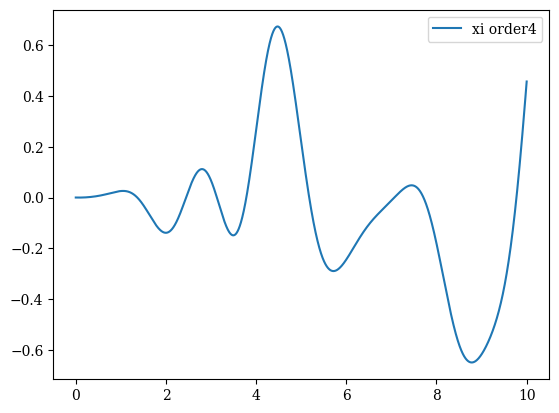

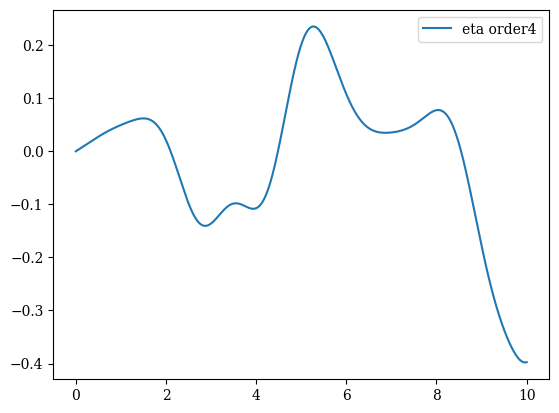

calculating term p: 5
omega 5: 0.040322195537598034


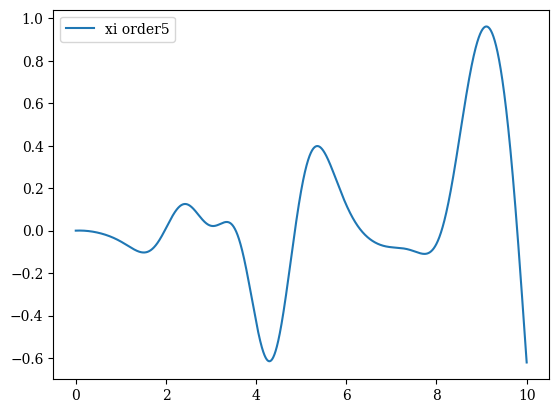

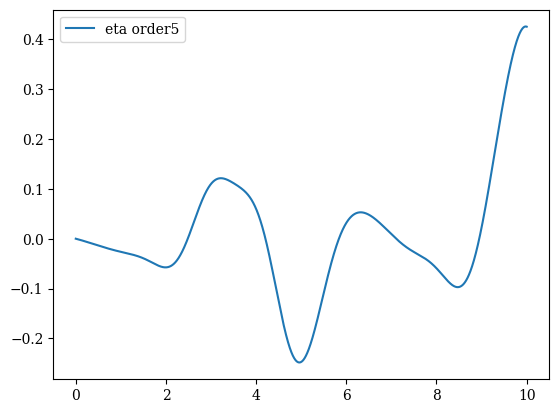

calculating term p: 6
omega 6: -0.02233637205267341


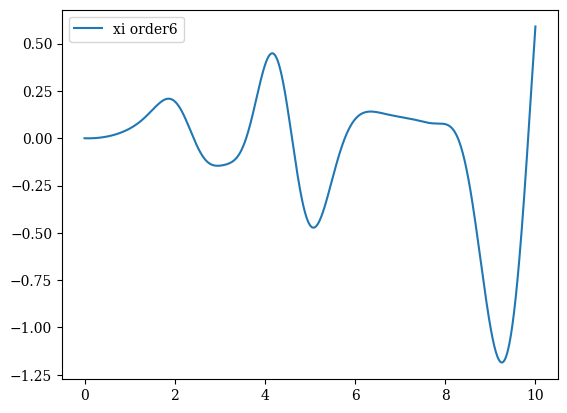

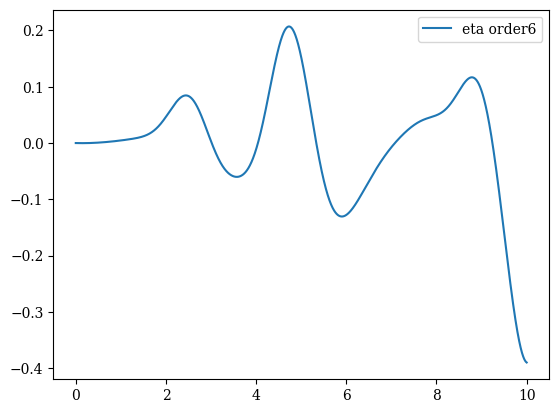

In [54]:
n_corrections = 6
w_list, xi_list, eta_list = [w_0], [xi_0], [eta_0]
xi_dot, eta_dot = [np.gradient(xi_0, t_eval)], [np.gradient(eta_0, t_eval)]

for p in range(1, n_corrections + 1):

    print(f"calculating term p: {p}")
    w_n = LKV.calc_w_n(w_list, xi_list, xi_dot, eta_list, t_eval)
    print(f"omega {p}: {w_n}")

    xi_forcing = LKV.calculate_forcing_xi(w_n, w_list, eta_list, xi_list, xi_dot)
    xi_forcing_interp = CubicSpline(t_eval, xi_forcing)

    eta_forcing = LKV.calculate_forcing_eta(w_n, w_list, eta_list, xi_list, eta_dot, alpha)
    eta_forcing_interp = CubicSpline(t_eval, eta_forcing)

    def lv_nth_order(t, z):
        x, y = z
        dx = - y + xi_forcing_interp(t)
        dy = alpha * x + eta_forcing_interp(t)
        return np.array([dx / np.sqrt(alpha), dy / np.sqrt(alpha)])

    # solving x_n ode
    xi_nth_order, eta_nth_order = (numerical.solve_ode_equation(lv_nth_order, t_span, t_eval, np.array([0,0])))  

    w_list.append(w_n)
    xi_list.append(xi_nth_order)
    eta_list.append(eta_nth_order)
    xi_dot.append(np.gradient(xi_nth_order, t_eval))
    eta_dot.append(np.gradient(eta_nth_order, t_eval))

    
    if p == 1:
        plt.plot(t_eval, (- xi_list[0] * eta_list[0] - w_list[1] * xi_dot[0]), label = "1st-order xi forcing teor")
        plt.plot(t_eval, xi_forcing_interp(t_eval), "--", label = "1st-order xi forcing found")
        plt.legend()
        plt.show()

        plt.plot(t_eval, alpha * xi_list[0] * eta_list[0] - w_list[1] * eta_dot[0], label = "1st-order eta forcing teor")
        plt.plot(t_eval, eta_forcing_interp(t_eval), "--", label = "1st-order eta forcing found")
        plt.legend()
        plt.show()

    if p == 2:
        plt.plot(t_eval, (- w_list[2] * xi_dot[0] - w_list[1] * xi_dot[1] - xi_list[0] * eta_list[1] - eta_list[0] * xi_list[1]), label = "2nd-order xi forcing teor")
        plt.plot(t_eval, xi_forcing_interp(t_eval), "--", label = "2nd-order xi forcing found")
        plt.legend()
        plt.show()

        plt.plot(t_eval, (- w_list[2] * eta_dot[0] - w_list[1] * eta_dot[1] + alpha * (eta_list[0] * xi_list[1] + xi_list[0] * eta_list[1])), label = "2nd-order eta forcing teor")
        plt.plot(t_eval, eta_forcing_interp(t_eval), "--", label = "2nd-order eta forcing found")
        plt.legend()
        plt.show()

    plt.plot(t_eval, xi_nth_order, label=f"xi order{p}")
    plt.legend()
    plt.show()

    plt.plot(t_eval, eta_nth_order, label=f"eta order{p}")
    plt.legend()
    plt.show()

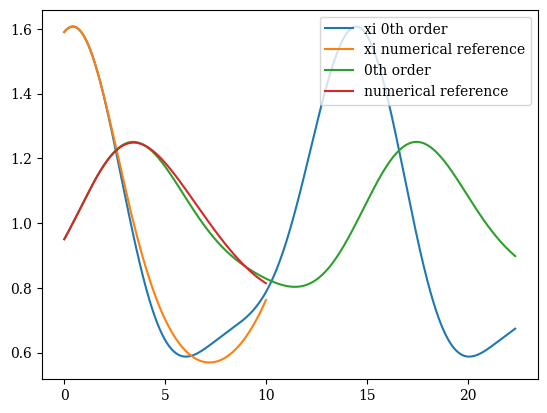

In [55]:
# don't forget xi_0 is defined in tau!
plt.plot(t_eval / (np.sqrt(alpha) + epsilon * w_list[1]), 1 + epsilon * xi_0 + epsilon ** 2 * xi_list[1], label="xi 0th order")
plt.plot(t_eval, x, label="xi numerical reference")

plt.plot(t_eval / (np.sqrt(alpha) + epsilon * w_list[1]), 1 + epsilon * eta_0 + epsilon ** 2 * eta_list[1], label="0th order")
plt.plot(t_eval, y, label="numerical reference")
plt.legend()

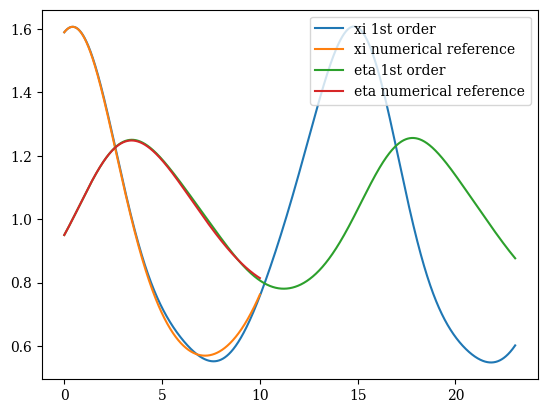

In [56]:
plt.plot(t_eval / (np.sqrt(alpha) + epsilon * w_list[1] + epsilon ** 2 * w_list[2]), 1 + epsilon * xi_0 + epsilon ** 2 * xi_list[1] + epsilon ** 3 * xi_list[2], label="xi 1st order")
plt.plot(t_eval, x, label="xi numerical reference")

plt.plot(t_eval / (np.sqrt(alpha) + epsilon * w_list[1] + epsilon ** 2 * w_list[2]), 1 + epsilon * eta_0 + epsilon ** 2 * eta_list[1] + epsilon ** 3 * eta_list[2], label="eta 1st order")
plt.plot(t_eval, y, label="eta numerical reference")
plt.legend()

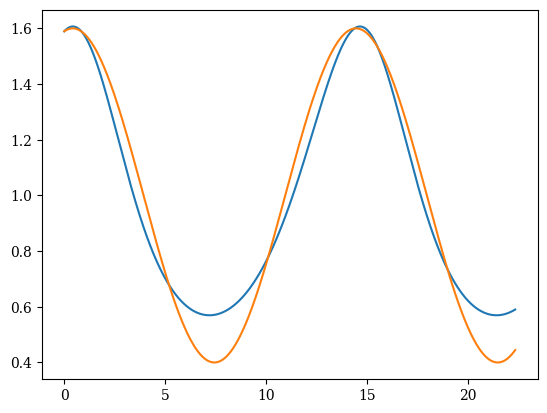

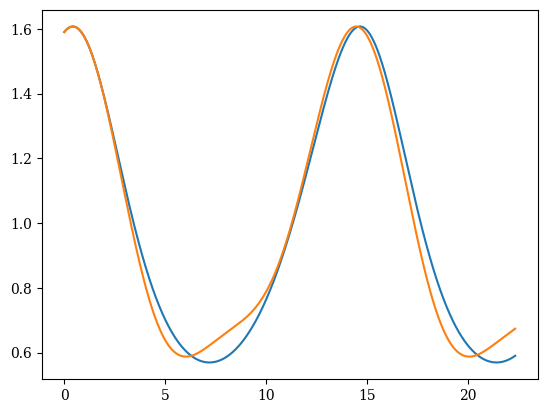

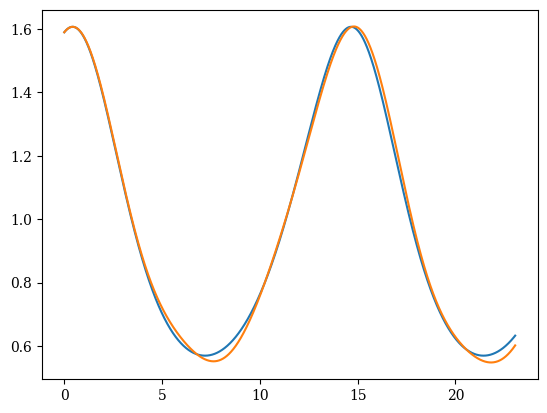

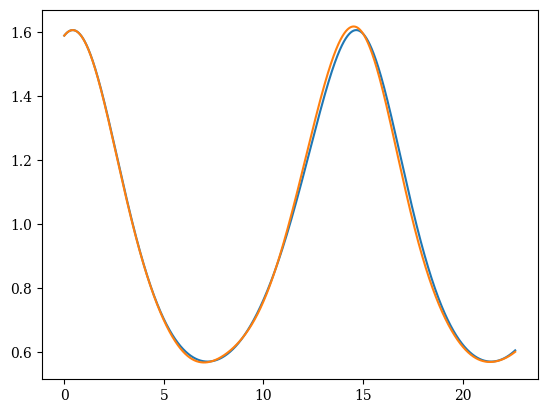

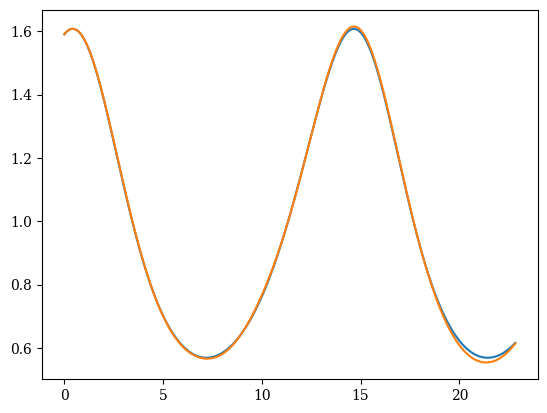

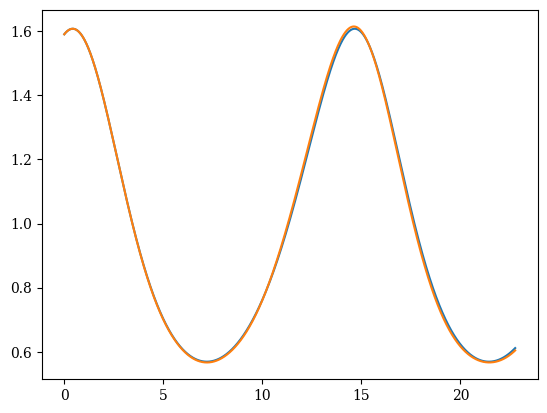

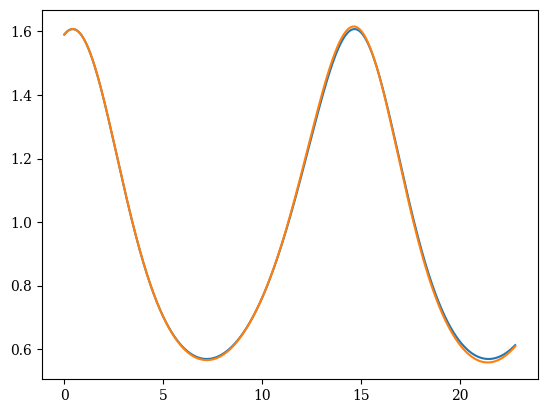

In [57]:
w_final = []
xi_final = []
error_dash = []

for i in range(len(w_list)):

    if i == 0:
        w_loop = np.sqrt(alpha)
        xi_loop = xi_list[0]
    else:
        w_loop = w_final[i - 1] + (epsilon ** i)  * w_list[i]
        xi_loop  = xi_final[i - 1] + (epsilon ** i) * xi_list[i]

    w_final.append(w_loop)
    xi_final.append(xi_loop)

    t_span_loop = (0, t_span[-1]/w_loop)
    t_eval_loop = np.linspace(t_span_loop[0], t_span_loop[1], N)
    sol_loop = numerical.solve_ode_equation(ode, t_span_loop, t_eval_loop, [x0, y0])
    x_loop, y_loop = sol_loop 

    error_dash.append(np.mean(np.abs(1 + epsilon * xi_loop - x_loop)))

    plt.plot(t_eval_loop, x_loop)
    plt.plot(t_eval_loop, 1 + epsilon * xi_loop)
    plt.show()

In [58]:
error_dash

[np.float64(0.07954102394995057),
 np.float64(0.04091138036830193),
 np.float64(0.014326201207678045),
 np.float64(0.010766435650879853),
 np.float64(0.004325694923080198),
 np.float64(0.00532324558449083),
 np.float64(0.004867483537365633)]

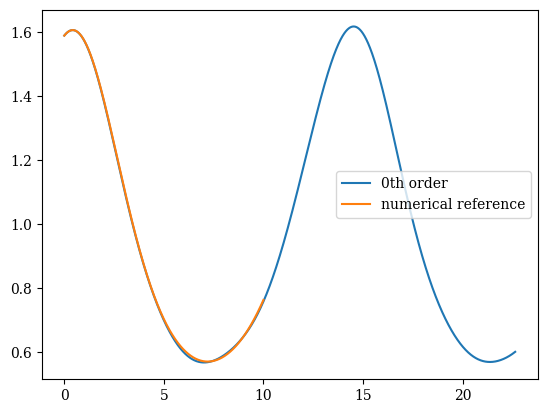

In [59]:
# don't forget xi_0 is defined in tau!
plt.plot(t_eval / (np.sqrt(alpha) + epsilon * w_list[1] + epsilon ** 2 * w_list[2] + epsilon ** 3 * w_list[3]), 1 + epsilon * xi_0 + epsilon ** 2 * xi_list[1] + epsilon ** 3 * xi_list[2] + epsilon ** 4 * xi_list[3], label="0th order")
plt.plot(t_eval, x, label="numerical reference")
plt.legend()

In [60]:
# w_2 according to grozdanovski
A = xi_0.max()
- (A ** 2 * np.sqrt(alpha))/24 - (A ** 2 * alpha * np.sqrt(alpha))/24

np.float64(-0.03225304447449199)